## 0. Imports & Setup

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
pd.options.display.float_format='{:.3f}'.format
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.figsize'] = [8,8]
warnings.filterwarnings('ignore')

In [3]:
TARGET = 'precio'
SEED = 42

In [4]:
df = pd.read_csv("autocasion_procesado.csv")

## 1. Quick Clean

In [5]:
ints = ['Cambio', 'puertas', 'plazas', 'cilindros', 'month', 'year', 'Garantía']
df[ints] = df[ints].round(decimals=0)

In [6]:
df['cilindrada_cm3'] = df['cilindrada_cm3'].apply(lambda x: x / 1000 if x > 100 else x)

In [7]:
for col in df.columns:
    df[col] = df[col].round(decimals=4)

## 2. Split

In [8]:
X = df.drop(TARGET, axis=1)
y = df[TARGET]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

## 3. Understanding the data

In [10]:
X_train.head()

,Kilómetros,Cambio,Potencia (cv),Garantía,largo,ancho,alto,batalla_mm,peso_masa_kg,puertas,plazas,cilindrada_cm3,cilindros,urbano,carretera,medio,co2,deposito,month,year,maletero_1,maletero_2,Distintivo ambiental_0 EMISIONES,Distintivo ambiental_B,Distintivo ambiental_C,Distintivo ambiental_ECO,Distintivo ambiental_nan,carroceria_Berlina,carroceria_Combi,carroceria_Convertible,carroceria_Coupe,carroceria_Monovolumen,carroceria_Pick-Up,carroceria_Pick-Up Doble Cabina,carroceria_Roadster,carroceria_Stationwagon,carroceria_Targa,carroceria_Todo Terreno,carroceria_nan,combustible_Corriente eléctrica,combustible_Diesel,combustible_Diesel y corriente eléctrica,combustible_Gasolina,combustible_Gasolina y corriente eléctrica,combustible_Gasolina/gas,combustible_Mixto Gasolina/Etanol,combustible_nan,sobrealimentacion_Compresor Lisholm,sobrealimentacion_Compresor de raices,sobrealimentacion_Compresor y turbo,sobrealimentacion_Doble turbo,sobrealimentacion_Tipo de sobrealimentador,sobrealimentacion_Turbo,sobrealimentacion_Turbo de geometría variable,sobrealimentacion_nan
79314,12200.000,0.000,218.000,0.000,4600.000,1855.000,1685.000,2690.000,2205.000,5.000,5.000,2.487,4.000,470.000,470.000,460.000,105.000,5500.000,1.000,2023.000,580.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
76239,139501.000,0.000,114.000,12.000,4450.000,1780.000,1570.000,2635.000,1870.000,5.000,5.000,1.600,4.000,800.000,580.000,650.000,151.000,6000.000,4.000,2019.000,380.000,1.270,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
45857,9000.000,0.000,150.000,24.000,4419.000,1796.000,1562.000,2729.000,2090.000,5.000,5.000,1.950,4.000,0.000,0.000,0.000,39.333,4300.000,3.000,2023.000,445.000,1.530,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
63361,128936.000,1.000,115.000,12.000,4440.000,1817.000,1426.000,2605.000,1950.000,2.000,4.000,1.560,4.000,630.000,410.000,490.000,128.000,6000.000,12.000,2013.000,226.000,465.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73114,89200.000,0.000,150.000,12.000,4545.333,1789.333,1477.000,2659.333,1940.000,5.000,5.000,1.911,4.000,0.000,0.000,0.000,110.333,4433.333,1.000,2018.000,527.667,1.095,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000


In [11]:
X_train.shape

(70114, 55)

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70114 entries, 79314 to 15795
Data columns (total 55 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Kilómetros                                     70114 non-null  float64
 1   Cambio                                         70114 non-null  float64
 2   Potencia (cv)                                  70114 non-null  float64
 3   Garantía                                       70114 non-null  float64
 4   largo                                          70114 non-null  float64
 5   ancho                                          70114 non-null  float64
 6   alto                                           70114 non-null  float64
 7   batalla_mm                                     70114 non-null  float64
 8   peso_masa_kg                                   70114 non-null  float64
 9   puertas                                        7011

In [13]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Kilómetros,70114.000,65405.371,52846.129,0.000,21915.000,56000.000,96286.750,272000.000
Cambio,70114.000,0.531,0.499,0.000,0.000,1.000,1.000,1.000
Potencia (cv),70114.000,149.032,65.428,1.000,110.000,130.000,163.000,490.000
Garantía,70114.000,16.583,13.556,0.000,12.000,12.000,12.000,400.000
largo,70114.000,4384.883,266.373,3430.000,4228.000,4382.000,4559.000,5302.000
ancho,70114.000,1812.260,57.841,1595.000,1783.000,1813.667,1841.000,2032.000
alto,70114.000,1533.555,85.771,1225.000,1463.000,1521.667,1598.000,1869.000
batalla_mm,70114.000,2662.623,114.191,2300.000,2595.667,2654.333,2710.000,3135.000
peso_masa_kg,70114.000,1953.173,290.784,1055.000,1770.000,1920.000,2110.000,3000.000
puertas,70114.000,4.806,0.584,2.000,5.000,5.000,5.000,5.000


## 4. Feature Selection

In [14]:
# Identify and drop columns where a single value makes up more than 99% of the column's data
to_drop = [col for col in X_train.columns if X_train[col].value_counts(normalize=True).max() > 0.99]

In [15]:
to_drop

['carroceria_Combi',
 'carroceria_Convertible',
 'carroceria_Pick-Up',
 'carroceria_Pick-Up Doble Cabina',
 'carroceria_Roadster',
 'carroceria_Targa',
 'combustible_Corriente eléctrica',
 'combustible_Diesel y corriente eléctrica',
 'combustible_Gasolina/gas',
 'combustible_Mixto Gasolina/Etanol',
 'sobrealimentacion_Compresor Lisholm',
 'sobrealimentacion_Compresor de raices',
 'sobrealimentacion_Compresor y turbo',
 'sobrealimentacion_Doble turbo',
 'sobrealimentacion_Tipo de sobrealimentador']

In [16]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [17]:
mi = mutual_info_regression(X_train, y_train)
mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

In [18]:
def plot_corr(X_corr_with_target):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=X_corr_with_target.index, y=X_corr_with_target.values, palette='coolwarm', hue=X_corr_with_target.index)
    plt.title('Correlación de las columnas con "precio"')
    plt.xticks(rotation=90)
    plt.ylabel('Correlación')
    plt.show()

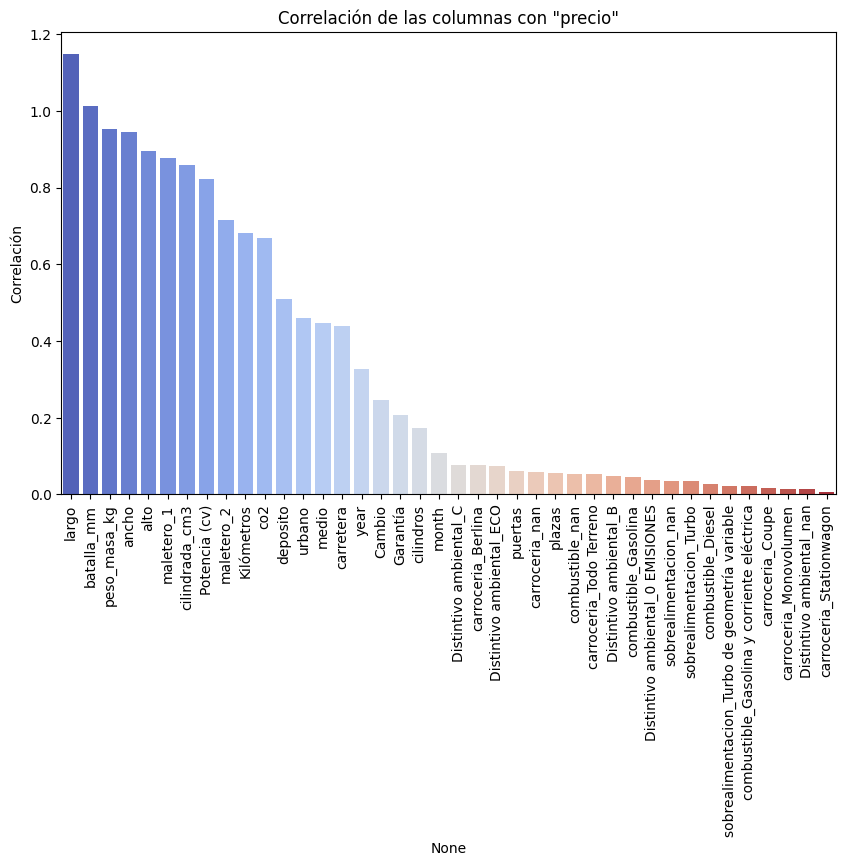

In [19]:
plot_corr(mi_series)

In [20]:
mi_series

largo                                           1.147
batalla_mm                                      1.011
peso_masa_kg                                    0.951
ancho                                           0.944
alto                                            0.894
maletero_1                                      0.876
cilindrada_cm3                                  0.859
Potencia (cv)                                   0.823
maletero_2                                      0.715
Kilómetros                                      0.681
co2                                             0.668
deposito                                        0.509
urbano                                          0.459
medio                                           0.448
carretera                                       0.440
year                                            0.328
Cambio                                          0.245
Garantía                                        0.208
cilindros                   

In [21]:
threshold = 0.0

selected_features = mi_series[mi_series > threshold].index

selected_features

Index(['largo', 'batalla_mm', 'peso_masa_kg', 'ancho', 'alto', 'maletero_1',
       'cilindrada_cm3', 'Potencia (cv)', 'maletero_2', 'Kilómetros', 'co2',
       'deposito', 'urbano', 'medio', 'carretera', 'year', 'Cambio',
       'Garantía', 'cilindros', 'month', 'Distintivo ambiental_C',
       'carroceria_Berlina', 'Distintivo ambiental_ECO', 'puertas',
       'carroceria_nan', 'plazas', 'combustible_nan',
       'carroceria_Todo Terreno', 'Distintivo ambiental_B',
       'combustible_Gasolina', 'Distintivo ambiental_0 EMISIONES',
       'sobrealimentacion_nan', 'sobrealimentacion_Turbo',
       'combustible_Diesel', 'sobrealimentacion_Turbo de geometría variable',
       'combustible_Gasolina y corriente eléctrica', 'carroceria_Coupe',
       'carroceria_Monovolumen', 'Distintivo ambiental_nan',
       'carroceria_Stationwagon'],
      dtype='object')

In [22]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [23]:
def plot_numeric(data, column_name, axes, bins=30):
    sns.histplot(data[column], bins=bins, kde=True, color="blue", edgecolor="black", alpha=0.7, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}", fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

In [24]:
def plot_categoric(data, column_name, axes):
    sns.countplot(data=data, x=column, color="blue", edgecolor="black", alpha=0.7, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}", fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel("Count", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

In [25]:
def plot_counts(data, bins=30):
    num_cols = len(data.columns)

    cols = 3
    rows = math.ceil(num_cols / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(data.columns):
        if data[column].nunique() < 10:
            sns.countplot(data=data, x=column, color="blue", edgecolor="black", alpha=0.7, ax=axes[i])
            axes[i].set_title(f"Distribution of {column}", fontsize=14)
            axes[i].set_xlabel(column, fontsize=12)
            axes[i].set_ylabel("Count", fontsize=12)
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].grid(axis="y", linestyle="--", alpha=0.6)
        else:
            sns.histplot(data[column], bins=bins, kde=True, color="blue", edgecolor="black", alpha=0.7, ax=axes[i])
            axes[i].set_title(f"Distribution of {column}", fontsize=14)
            axes[i].set_xlabel(column, fontsize=12)
            axes[i].set_ylabel("Frequency", fontsize=12)
            axes[i].grid(axis="y", linestyle="--", alpha=0.6)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

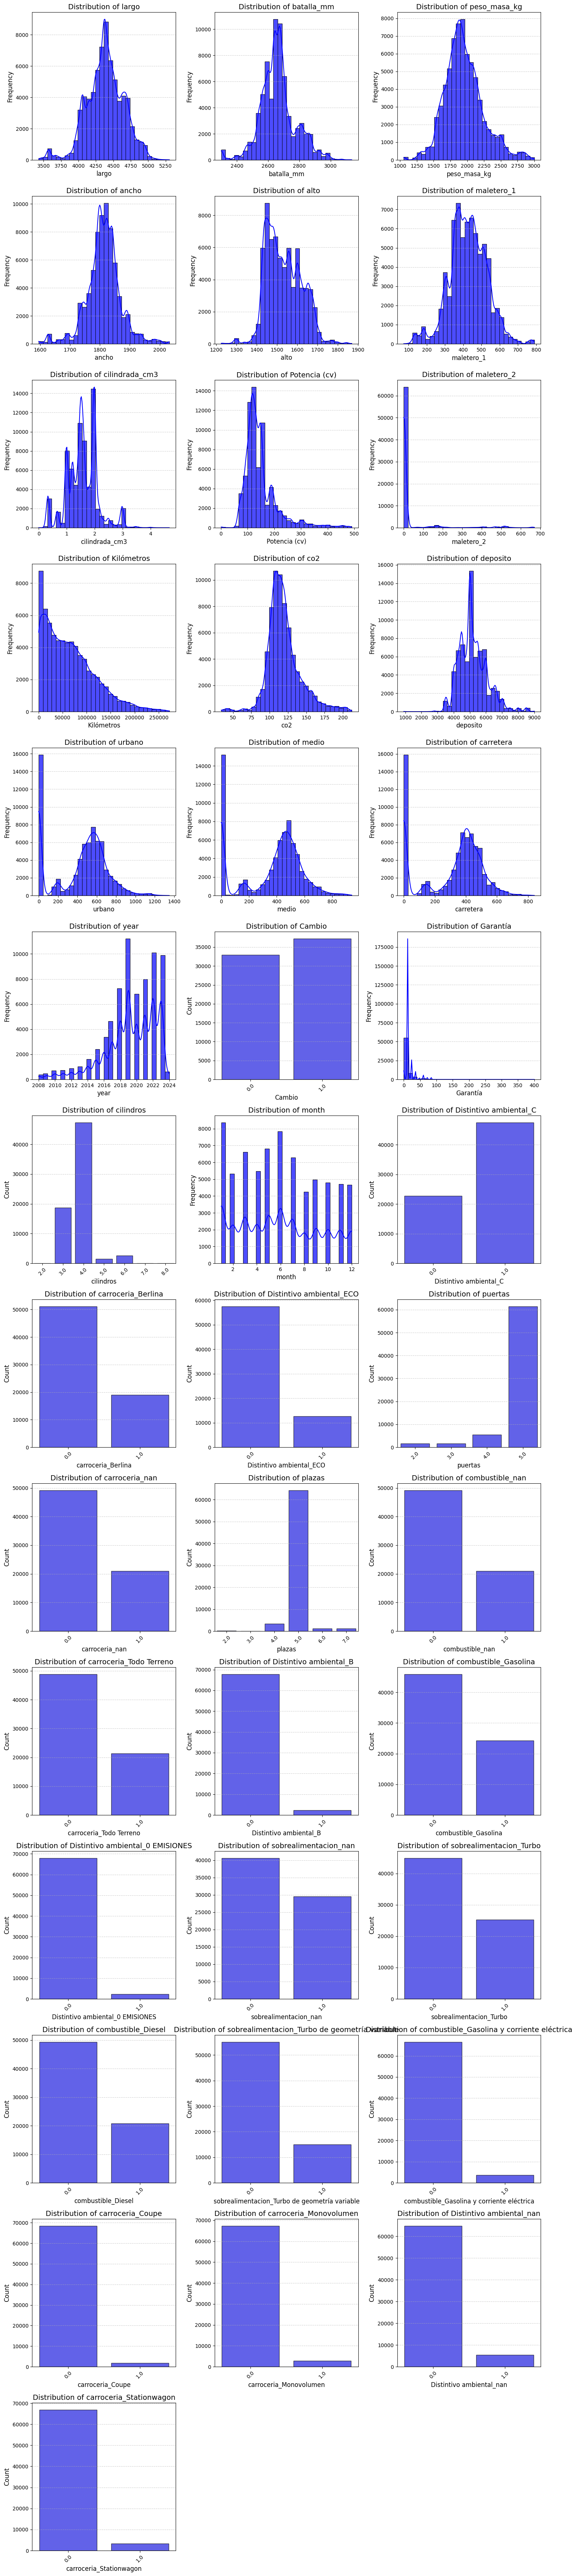

In [26]:
plot_counts(X_train)

In [27]:
def plot_box_plots(data, cols=3):
    filtered_data = data[[column for column in data.columns if data[column].nunique() > 2]]
    
    num_cols = len(filtered_data.columns)
    rows = math.ceil(num_cols / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))
    axes = axes.flatten()

    for i, column in enumerate(filtered_data.columns):
        axes[i].boxplot(filtered_data[column])
        axes[i].set_title(column)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

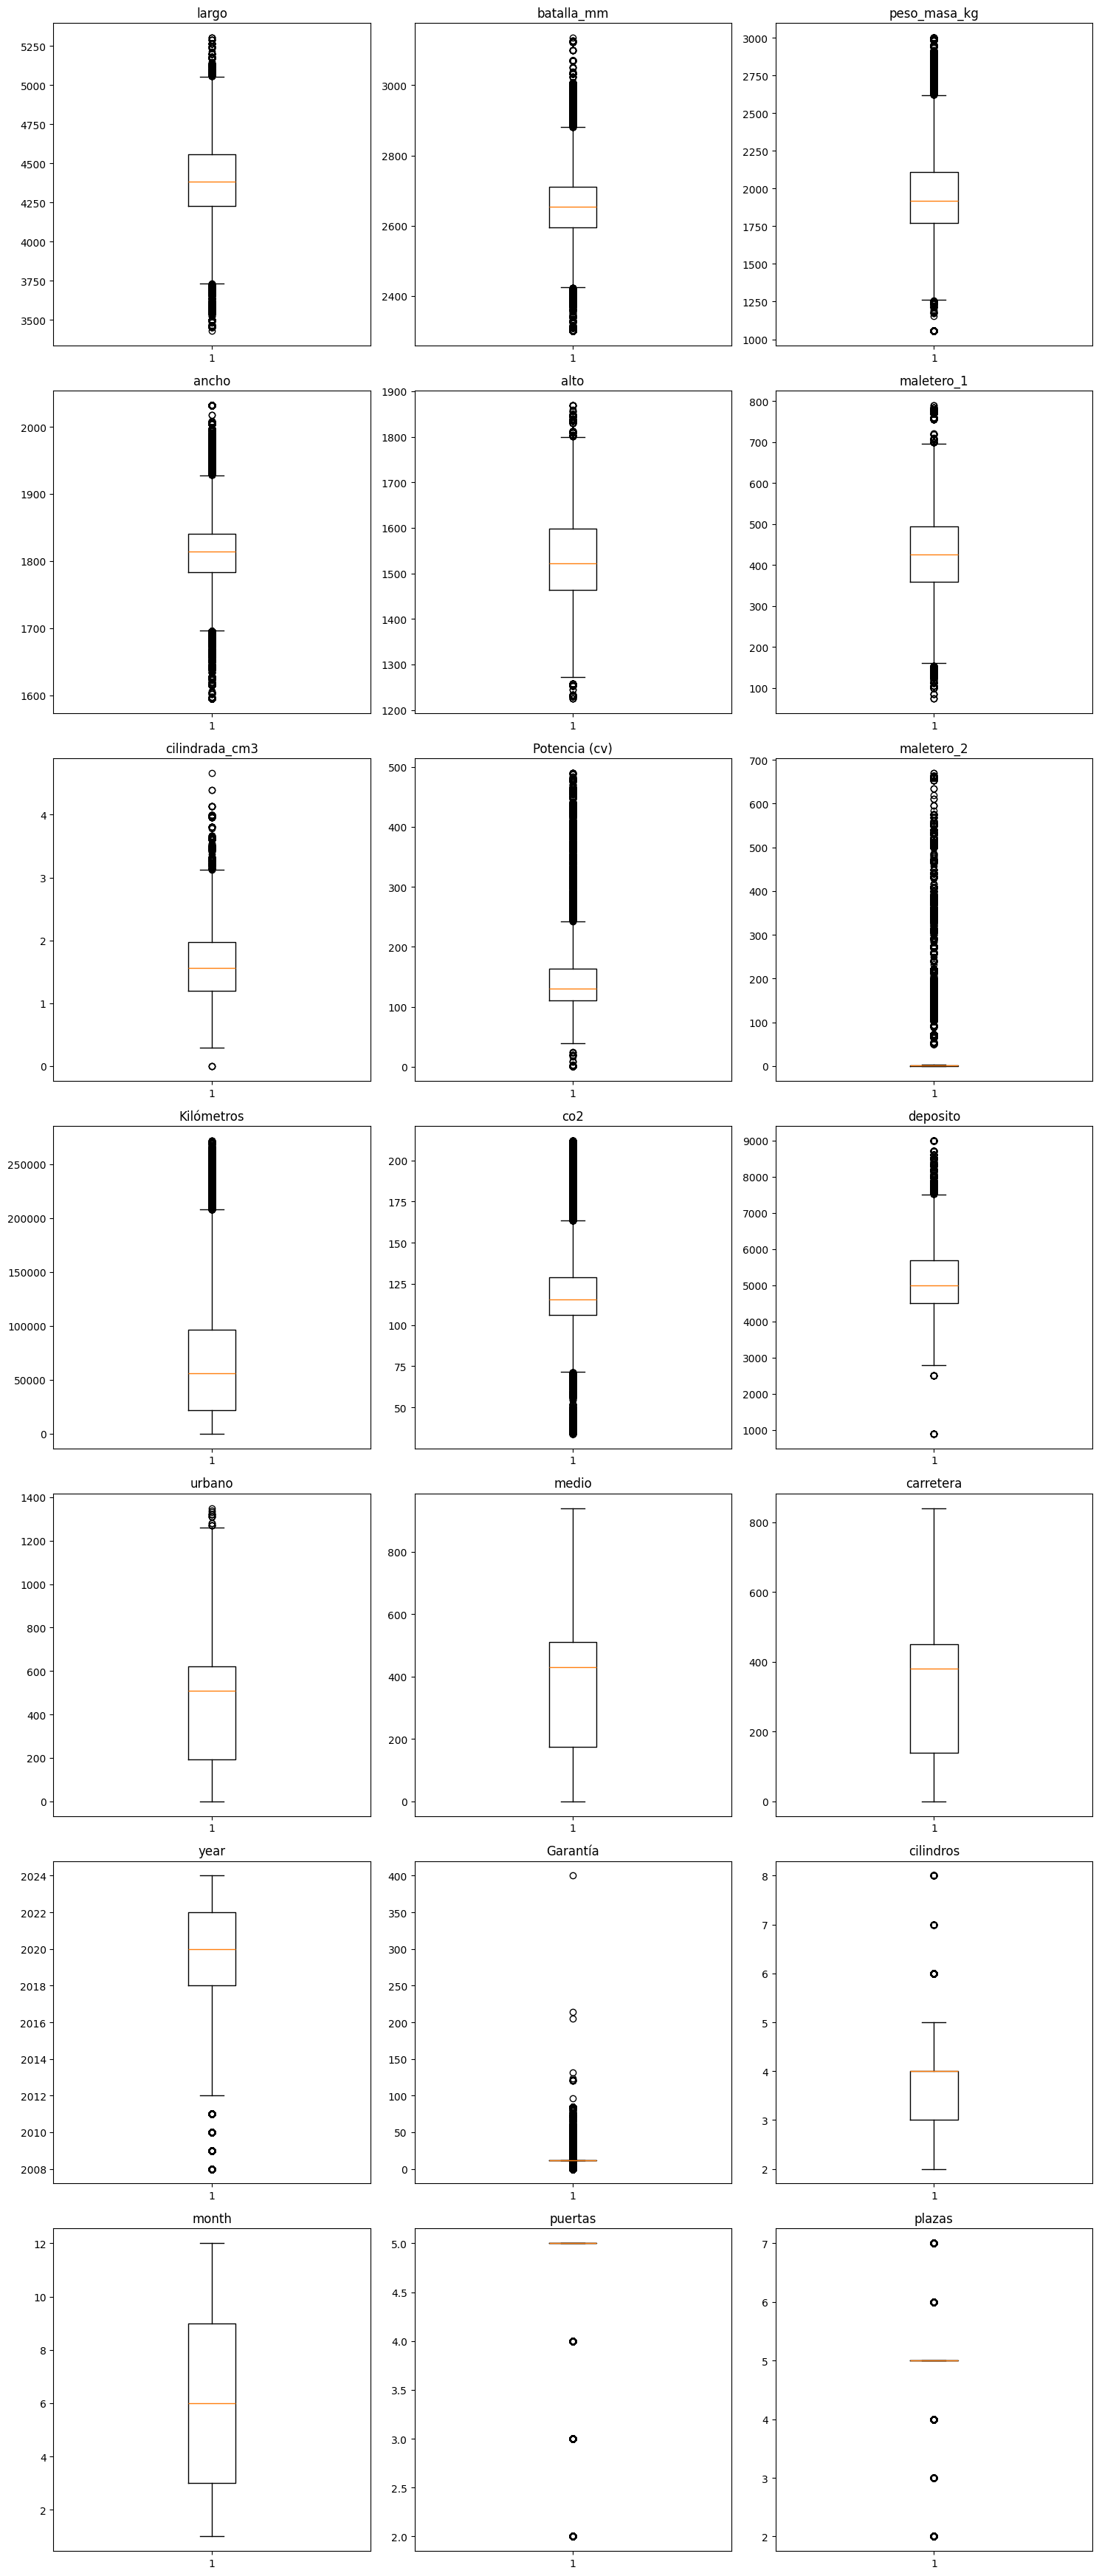

In [28]:
plot_box_plots(X_train)

## 5. Regression

In [84]:
models = {
    "Lasso": Lasso(random_state=SEED),
    "ElasticNet": ElasticNet(random_state=SEED),
    "Ridge": Ridge(random_state=SEED),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=SEED),
    "AdaBoost": AdaBoostRegressor(random_state=SEED),
    "ExtraTrees": ExtraTreesRegressor(random_state=SEED),
    "LightGBM": LGBMRegressor(random_state=SEED),
    "XGBoost": XGBRegressor(random_state=SEED),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=SEED),
}

In [30]:
model_names = list(models.keys())

In [31]:
def scale(scaler_X, scaler_y):
    
    if scaler_X is not None:
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    if scaler_y is not None:
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
    else:
        y_train_scaled = y_train
        y_test_scaled = y_test
        
    return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

In [80]:
def train_model(model_name, model, params, cv, scaler_X=None, scaler_y=None):

    print(f"Training {model_name}...")
    
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale(scaler_X, scaler_y)

    grid_search = GridSearchCV(estimator=model, 
                               param_grid=params, 
                               cv=cv, 
                               scoring='r2', 
                               n_jobs=-1,
                               verbose=1,
                               refit=True
                              )
    
    grid_search.fit(X_train_scaled, y_train_scaled)

    cv_results = grid_search.cv_results_
    best_model = grid_search.best_estimator_

    y_pred_scaled = best_model.predict(X_test_scaled)

    if scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
        y_test_actual = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))
    else:
        y_pred = y_pred_scaled
        y_test_actual = y_test_scaled
    
    mae = mean_absolute_error(y_test_actual, y_pred)
    mse = mean_squared_error(y_test_actual, y_pred)
    r2 = r2_score(y_test_actual, y_pred)

    return [model_name, mae, mse, r2], best_model, cv_results

In [81]:
def get_results(model_names, params, cv=3, scaler_X=None, scaler_y=None):
    
    selected_models = [models[name] for name in model_names]
    param_grids = [params[name] for name in model_names]
    
    results = []
    best_models = []

    for model_name, model, params in zip(model_names, selected_models, param_grids):
        
        result, best_model, cv_results = train_model(model_name, model, params, cv, scaler_X, scaler_y)
        results.append(result)
        best_models.append(best_model)
    
    model_names = [result[0] for result in results]
    best_model_params = [model.get_params() for model in best_models]
    
    display(pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'R2'], index=model_names))
    display(pd.DataFrame(best_model_params, index=model_names))

    return cv_results

### 1 - Simple & quick but $#!t models

In [34]:
linear_params = {
    "Lasso": {
        "alpha": [0.1, 1.0, 10.0],
        "fit_intercept": [True, False],
        "selection": ['cyclic', 'random']
    },
    "ElasticNet": {
        "alpha": [0.1, 1.0, 10.0],
        "l1_ratio": [0.1, 0.5, 0.9],
        "fit_intercept": [True, False],
        "max_iter": [1000, 5000, 10000]
    },
    "Ridge": {
        "alpha": [0.1, 1.0, 10.0],
        "fit_intercept": [True, False],
        'solver': ['auto', 'lbfgs', 'saga']
    },
    "Linear Regression": {
        "fit_intercept": [True, False],
    },
}

In [35]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

get_results(model_names[0:4], linear_params, 5, scaler_X, scaler_y)

Training Lasso...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Training ElasticNet...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Training Ridge...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Training Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,Model,MAE,MSE,R2
Lasso,Lasso,10604.350,5097317113.681,0.022
ElasticNet,ElasticNet,9166.052,4876661621.689,0.064
Ridge,Ridge,11622.586,4825288178.429,0.074
Linear Regression,Linear Regression,11628.476,4825271418.638,0.074


,alpha,copy_X,fit_intercept,max_iter,positive,precompute,random_state,selection,tol,warm_start,l1_ratio,solver,n_jobs
Lasso,0.100,True,False,1000.000,False,False,42.000,random,0.000,False,NaN,NaN,NaN
ElasticNet,0.100,True,False,1000.000,False,False,42.000,cyclic,0.000,False,0.100,NaN,NaN
Ridge,10.000,True,False,NaN,False,NaN,42.000,NaN,0.000,NaN,NaN,auto,NaN
Linear Regression,NaN,True,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
params = {
    "AdaBoost": {
        "n_estimators": [10, 50, 100],
        "learning_rate": [0.4, 0.5, 0.6, 0.7],
    }
}
get_results(['AdaBoost'], params, 5)

Training AdaBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


,Model,MAE,MSE,R2
AdaBoost,AdaBoost,9268.152,2229922881.568,0.572


,estimator,learning_rate,loss,n_estimators,random_state
AdaBoost,None,0.700,linear,50,42


In [54]:
params = {
    "AdaBoost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.3, 0.5, 0.7],
    }
}
get_results(['AdaBoost'], params)

Training AdaBoost...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


,Model,MAE,MSE,R2
AdaBoost,AdaBoost,10296.312,2124325680.800,0.592


,estimator,learning_rate,loss,n_estimators,random_state
AdaBoost,None,0.500,linear,50,42


In [50]:
params = {
    "XGBoost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [None, 2, 5],
        "subsample": [0.1, 0.5, 1.0],
        "colsample_bytree": [0.1, 0.7, 1.0],
        "reg_alpha": [0, 0.05, 0.1],
        "reg_lambda": [0, 0.05, 0.1],
        "eval_metric": ["rmse"]
    }
}

get_results(['XGBoost'], params)

Training XGBoost...
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits


,Model,MAE,MSE,R2
XGBoost,XGBoost,4372.595,1963948035.642,0.623


,objective,base_score,booster,callbacks,colsample_bylevel,colsample_bynode,colsample_bytree,device,early_stopping_rounds,enable_categorical,eval_metric,feature_types,gamma,grow_policy,importance_type,interaction_constraints,learning_rate,max_bin,max_cat_threshold,max_cat_to_onehot,max_delta_step,max_depth,max_leaves,min_child_weight,missing,monotone_constraints,multi_strategy,n_estimators,n_jobs,num_parallel_tree,random_state,reg_alpha,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
XGBoost,reg:squarederror,None,None,None,None,None,0.700,None,None,False,rmse,None,None,None,None,None,0.050,None,None,None,None,None,None,None,NaN,None,None,50,None,None,42,0,0.050,None,None,1.000,None,None,None


In [51]:
params = {
    "ExtraTrees": {
        "n_estimators": [50, 100, 150],
        "max_depth": [None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2]
    }
}

get_results(['ExtraTrees'], params)

Training ExtraTrees...
Fitting 3 folds for each of 18 candidates, totalling 54 fits


,Model,MAE,MSE,R2
ExtraTrees,ExtraTrees,2577.663,1734073484.035,0.667


,bootstrap,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,monotonic_cst,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
ExtraTrees,False,0.000,squared_error,None,1.000,None,None,0.000,1,5,0.000,None,50,None,False,42,0,False


In [44]:
params = {
    "LightGBM": {
        "n_estimators": [50, 100, 150],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [None, 1, 2],
        "num_leaves": [20, 25, 30],
        "subsample": [0.5, 0.6, 0.7],
        "colsample_bytree": [0.5, 0.6, 0.7],
        "verbosity": [-1]
    }
}

get_results(['LightGBM'], params)

Training LightGBM...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits


,Model,MAE,MSE,R2
LightGBM,LightGBM,4595.341,1361665306.487,0.739


,boosting_type,class_weight,colsample_bytree,importance_type,learning_rate,max_depth,min_child_samples,min_child_weight,min_split_gain,n_estimators,n_jobs,num_leaves,objective,random_state,reg_alpha,reg_lambda,subsample,subsample_for_bin,subsample_freq,verbosity
LightGBM,gbdt,None,0.500,split,0.100,None,20,0.001,0.000,150,None,20,None,42,0.000,0.000,0.500,200000,0,-1


In [52]:
params = {
   "Decision Tree": {
        'max_depth': [None, 10, 20],
        'min_samples_split': [5, 10, 15, 30],
        'min_samples_leaf': [2, 4, 6, 8],
        'criterion': ['squared_error'],
    }
}

get_results(['Decision Tree'], params)

Training Decision Tree...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


,Model,MAE,MSE,R2
Decision Tree,Decision Tree,3032.472,826128616.603,0.841


,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,monotonic_cst,random_state,splitter
Decision Tree,0.000,squared_error,None,None,None,0.000,6,15,0.000,None,42,best


In [53]:
params = {
    "KNN": {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ['uniform', 'distance'],
        "algorithm": ['ball_tree', 'kd_tree'],
        "leaf_size": [10, 20]
    }
}

scaler_X = MinMaxScaler()

get_results(['KNN'], params, scaler_X=scaler_X)

Training KNN...
Fitting 3 folds for each of 32 candidates, totalling 96 fits


,Model,MAE,MSE,R2
KNN,KNN,3135.448,2039908802.925,0.608


,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
KNN,ball_tree,10,minkowski,None,None,3,2,distance


In [56]:
params = {
    "Random Forest": {
        "n_estimators": [100],
        "max_depth": [None, 5, 10],
        "min_samples_split": [5, 10],
        "min_samples_leaf": [2, 5],
        "bootstrap": [False]
    }
}

get_results(['Random Forest'], params)

Training Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


,Model,MAE,MSE,R2
Random Forest,Random Forest,3007.998,858587702.228,0.835


,bootstrap,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,monotonic_cst,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
Random Forest,False,0.000,squared_error,None,1.000,None,None,0.000,5,5,0.000,None,100,None,False,42,0,False


In [151]:
def try_params(param_name, param_arr, **kwargs):
    
    model = RandomForestRegressor()
    
    results = []
    
    for i, n in enumerate(param_arr):
    
        print(f"Fitting with {n} {param_name}...")

        params = {k: v for k, v in kwargs.items() if k != param_name}
        params[param_name] = n
         
        model.set_params(**params)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    
        result = {
            "MAE": mae,
            "MSE": mse,
            "R2": r2
        }
        
        results.append(result)
        display(pd.DataFrame([result], index=[i]))

    return results

In [146]:
n_estimator_results = try_params("n_estimators", [10, 50, 100, 200], warm_start=True, bootstrap=False)

Fitting with 10 n_estimators...
{'warm_start': True, 'bootstrap': False, 'n_estimators': 10}


,index,MAE,MSE,R2
0,0,2599.784,1005659269.654,0.807


Fitting with 50 n_estimators...
{'warm_start': True, 'bootstrap': False, 'n_estimators': 50}


,index,MAE,MSE,R2
1,1,2615.947,1031957208.873,0.802


Fitting with 100 n_estimators...
{'warm_start': True, 'bootstrap': False, 'n_estimators': 100}


,index,MAE,MSE,R2
2,2,2614.100,1031312219.908,0.802


Fitting with 200 n_estimators...
{'warm_start': True, 'bootstrap': False, 'n_estimators': 200}


,index,MAE,MSE,R2
3,3,2615.507,1032725570.174,0.802


In [152]:
n_estimator_results = try_params("min_samples_split", [2, 5], n_estimators=50, bootstrap=False)

Fitting with 2 min_samples_split...


,MAE,MSE,R2
0,2615.296,1030920513.486,0.802


Fitting with 5 min_samples_split...


,MAE,MSE,R2
1,2849.284,1374653804.010,0.736


In [153]:
n_estimator_results = try_params("min_samples_leaf", [2, 5], n_estimators=50, bootstrap=False, min_samples_split=2)

Fitting with 2 min_samples_leaf...


,MAE,MSE,R2
0,2844.827,1052600935.771,0.798


Fitting with 5 min_samples_leaf...


,MAE,MSE,R2
1,3008.053,858605703.533,0.835


In [154]:
n_estimator_results = try_params("min_samples_split", [2, 5], n_estimators=50, bootstrap=False, min_samples_leaf=5)

Fitting with 2 min_samples_split...


,MAE,MSE,R2
0,3008.160,858598436.029,0.835


Fitting with 5 min_samples_split...


,MAE,MSE,R2
1,3008.243,858590077.629,0.835


In [155]:
n_estimator_results = try_params("max_depth", [None, 5, 10], n_estimators=50, bootstrap=False, min_samples_leaf=5, min_samples_split=2)

Fitting with None max_depth...


,MAE,MSE,R2
0,3007.860,858591540.116,0.835


Fitting with 5 max_depth...


,MAE,MSE,R2
1,7254.413,3588927245.265,0.311


Fitting with 10 max_depth...


,MAE,MSE,R2
2,4078.899,872807745.895,0.832


In [156]:
n_estimator_results = try_params("max_depth", [7, 12], n_estimators=50, bootstrap=False, min_samples_leaf=5, min_samples_split=2)

Fitting with 7 max_depth...


,MAE,MSE,R2
0,5197.387,1062582249.742,0.796


Fitting with 12 max_depth...


,MAE,MSE,R2
1,3663.866,864331705.389,0.834


bro this makes no sense i give up

In [57]:
Image(url="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExaGE2MTV2d29ieXVqZ3lnMXYwamRndGgyMm80c2loNHpzcG4zczF1aCZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/G2JjsgMQoKoiuuWXLI/giphy.gif")

i am not going to lie i really dont think this is my thing i want to cry everything is just too abstract for me to be able to grasp without studying the math behind it but i think i'll save my sanity for something else like backend

chill it's just the weekly coderbyte u didnt get r2 > 0.9 ok so what it's not that deep at least you learnt stuff, in particular that you know with certainty this isnt your thing!